This is the basis of the ingredient parser. We take each individual ingredient, remove common stop words and the most frequently used ingredients (ie. butter, salt, water, etc) and then cluster them to create categories of interchangeable ingredients. 

# Imports

In [3]:
from sklearn.cluster import KMeans
# Basics
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import csv
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pickle as pkl


# natural language processing
import nltk
from textblob import TextBlob
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.corpus import stopwords
from ingreedypy import Ingreedy

# sklearn
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# gensim
from gensim import corpora, models, similarities, matutils

# Other
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df_vec = pd.read_pickle('df_07_2_vecs.pkl')
df_cbow = pd.read_pickle('df_07_2.pkl')

In [3]:
df = pd.DataFrame()

In [4]:
df['vec'] = df_vec.ingredient_avg
df['vec_list'] = df_vec.ingredient_ind
df['cbow'] = df_cbow.ingredients
df['title'] = df_cbow.title

In [5]:
df.dropna(inplace=True)

In [6]:
df.vec.isnull().any()

False

# Keep only nouns

In [7]:
nouns = ['NN','NNS']
only_nouns = []
# only_nouns_vecs = []
for i in range(len(df)):
    for j, ing in enumerate(df.iloc[i].cbow):
        temp_pos = pos_tag(ing)
        temp = [x[0] for x in temp_pos if x[1] in nouns]
#         print(len(ing), len(df.iloc[i].vec_list))
        try:
#             only_nouns_vecs.append(df.iloc[i].vec_list[j])
            only_nouns.append(temp)
        except:
            pass

# Filter Essential Ingredients Out

In [8]:
# ESSENTIAL INGREDIENTS:
essentials = ['flour','butter','salt','baking_soda','baking_powder','olive_oil','water','kosher_salt',
             'eggs','egg','sugar','brown_sugar','granulated_sugar','garlic','garlic_cloves','garlic_clove',
             'ice','equipment','unsalted_butter', 'unsalted_butter', 'cloves_garlic', 'melted_butter', 'oil',
             'pepper','egg_yolk','egg_white','egg_yolks','egg_whites']


In [9]:
len(only_nouns)

178437

In [10]:
# To form clusters of non-essential ingredients:
# go through list of ingredient cbows and remove ingredients that have the essentials in them
# also remove ingredients that are longer than four words long (usually not necessary)
# use kmeans to cluster them into 2-15-ish types of ingredients
# use word frequencies to determine which words are ingredients in each cluster and which are extraneous
# . --> these words list become the ingredients lists for each food type (instead of the manual dictionaires i made)
# pca to 3 topics, plot with tableau

In [11]:
# IF SUCCESSFUL:
# use clusters in ingredient parser to identify ingredients and replace them with similar items

In [12]:
non_essentials=[]
# non_ess_vecs = []
for i in range(len(only_nouns)):
    temp = []
    for word in only_nouns[i]:
        if word not in essentials:
            temp.append(word)
#     print(temp, only_nouns[i])
    if len(temp) == len(only_nouns[i]) and len(temp) != 0:
        try:
#             non_ess_vecs.append(only_nouns_vecs[i])
            non_essentials.append(temp)
        except:
            pass
    

In [13]:
len(non_essentials)

119500

# Word2Vec

In [88]:
import gensim
google_vec_file = '/Users/carliebadder/Downloads/GoogleNews-vectors-negative300.bin'
goog = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [17]:
# import gensim

# with open('epicurious_texts.pkl', 'rb') as f:
#     epicurious_texts = pkl.load(f)

In [18]:
# model = gensim.models.Word2Vec(epicurious_texts, size=200, window=5, min_count=1, workers=2, sg=1)

In [19]:
# word_vectors = model.wv
# with open('word_vectors.pkl', 'wb') as f:
#     pkl.dump(word_vectors, f)

In [4]:
with open('word_vectors.pkl', 'rb') as f:
    w2v = pkl.load(f)

In [15]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in w2v]
#     print(doc)
    return np.mean(word2vec_model[doc], axis=0)

In [16]:
non_essentials = [[w for w in x if w in w2v] for x in non_essentials]

In [17]:
non_essentials = [w for w in non_essentials if w != []]

In [18]:
non_ess_vecs = []
for ing in non_essentials:
    non_ess_vecs.append(document_vector(w2v,ing))

In [19]:
len(non_ess_vecs), len(non_essentials)

(119493, 119493)

# Kmeans Clustering

## Ingredients

In [26]:
vstack = np.vstack(non_ess_vecs)

In [27]:
km = KMeans(n_clusters=20)

In [28]:
km.fit(vstack)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
unique, counts = np.unique(km.labels_, return_counts=True)
np.asarray((unique, counts)).T

array([[    0,  1583],
       [    1, 20573],
       [    2,  8537],
       [    3,  2041],
       [    4,  9870],
       [    5,  3861],
       [    6,  7118],
       [    7,  4593],
       [    8,  7006],
       [    9, 12994],
       [   10,  1526],
       [   11,  9077],
       [   12,  1806],
       [   13,  7068],
       [   14,  3156],
       [   15,  8968],
       [   16,  1151],
       [   17,  2078],
       [   18,  5987],
       [   19,   500]])

In [30]:
df_clusters = pd.DataFrame()
df_clusters['ing'] = non_essentials
df_clusters['label'] = km.labels_
df_clusters['vec'] = non_ess_vecs

In [31]:
df_clusters.to_pickle('df_clusters.pkl')

In [25]:
df_clusters2 = pd.read_pickle('df_clusters.pkl')

In [32]:
# 0: baking addins/alcohol, 1: onions, 2: citrus juice, 3: broth/liquids,
# 4: veg, 5: vinegars/condiments, 6: cream/fruit , 7: herbs, 8: herbs, 9: meat/veg, 
# 10: baking-ing, 11: bell_pepper, 12: spices, 13: scallions, 
# 14: warm spices, 15: whipping_cream, 16: nuts/add-ins, 17: cheese, 18: milk,
# 19: herbs

In [91]:
x = (list(df_clusters[df_clusters['label']==14]['ing']))#[10000:11000]
# x

In [92]:
from collections import defaultdict
d = defaultdict(int)
for w in x:
    ww = ' '.join(w)
    d[ww]+=1

In [93]:
len(d), len(x)

(45, 3156)

In [94]:
Counter(d).most_common()

[('cinnamon', 1348),
 ('nutmeg', 573),
 ('cloves', 469),
 ('allspice', 345),
 ('cardamom', 181),
 ('star_anise', 94),
 ('cinnamon broken', 53),
 ('star_anise pods', 20),
 ('cinnamon inches', 8),
 ('star_anise pod', 7),
 ('cinnamon garnish', 5),
 ('cinnamon cinnamon', 4),
 ('cinnamon taste', 4),
 ('canela cinnamon', 4),
 ('cardamom pod', 3),
 ('mace nutmeg', 3),
 ('nutmeg nutmeg', 3),
 ('star_anise star_anise', 2),
 ('lemon cloves', 2),
 ('cloves cloves', 2),
 ('orange cloves', 2),
 ('star_anise nutmeg', 1),
 ('cinnamon ceylon', 1),
 ('baharat cinnamon', 1),
 ('canela cinnamon broken', 1),
 ('level cinnamon', 1),
 ('cassia_bark cinnamon', 1),
 ('lemon_juice cinnamon', 1),
 ('cinnamon ice_cream', 1),
 ('cm cinnamon', 1),
 ('cloves cloves ham', 1),
 ('teasoon cinnamon', 1),
 ('cinnamon flavor', 1),
 ('lemon_peel cloves', 1),
 ('cinnamon graham_crackers', 1),
 ('cinnamon see', 1),
 ('cloves pan', 1),
 ('cinnamon chocolate_sauce', 1),
 ('cinnamon dusting', 1),
 ('pinches cloves', 1),
 ('clo

## spice pca

In [54]:
spice_list = ['cumin','allspice','black_peppercorns','coriander','fennel_seeds','chili_powder','turmeric']
spice_vecs = [model[w] for w in spice_list]
spice_vecs_stack = np.vstack(spice_vecs)

In [152]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

spice_pca = (PCA(n_components=3))
spice_pca_res = (spice_pca.fit_transform(spice_vecs_stack))


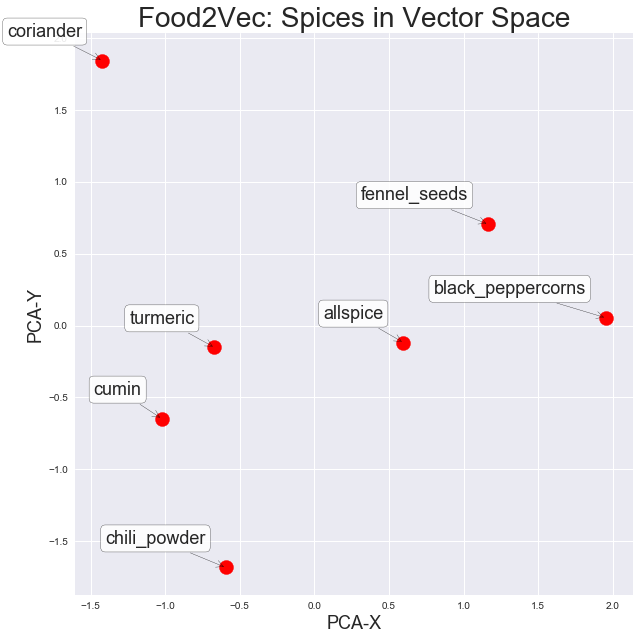

In [153]:
plt.subplots(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    spice_pca_res[:, 0], spice_pca_res[:, 1], marker='o', c='r', s=200)

for label, x, y in zip(spice_list, spice_pca_res[:, 0], spice_pca_res[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',fontsize=18,
        bbox=dict(boxstyle='round,pad=0.25', fc='white', alpha=0.9),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.xlabel('PCA-X', fontsize=18)
plt.ylabel('PCA-Y', fontsize=18)
plt.title('Food2Vec: Spices in Vector Space',fontsize=28)
plt.show()


## Veg pca

In [129]:
veg_list = ['cucumber','avocado','lettuce',
           'milk','cream','coconut_milk']
veg_colors = ['g','g','g',
             'b','b','b']
veg_vecs = [model[w] for w in veg_list]
veg_vecs_stack = np.vstack(veg_vecs)

In [130]:
veg_pca = PCA(n_components=3)
veg_pca_res = veg_pca.fit_transform(veg_vecs_stack)

In [137]:
# normalize to create the circle image - maybe use images instead of text labels

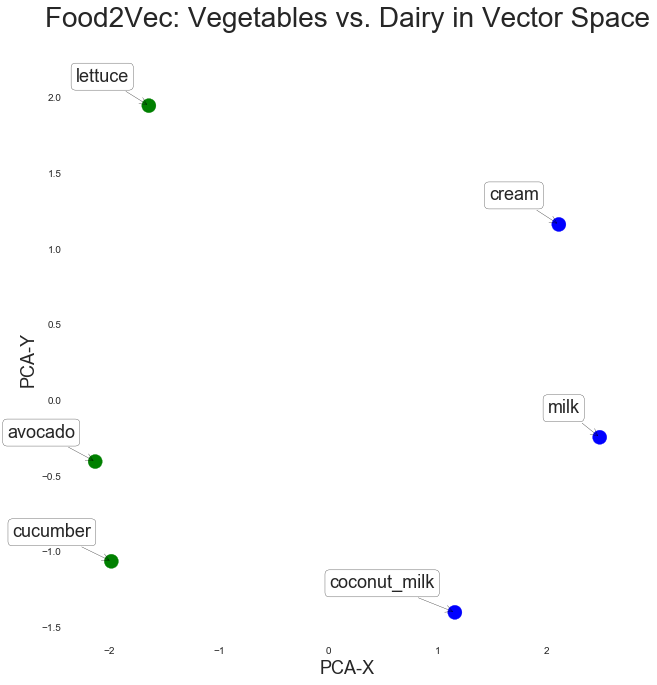

In [136]:
plt.subplots(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    veg_pca_res[:, 0], veg_pca_res[:, 1], marker='o', c=veg_colors, s=200)

for label, x, y in zip(veg_list, veg_pca_res[:, 0], veg_pca_res[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',fontsize=18,
        bbox=dict(boxstyle='round,pad=0.25', fc='white', alpha=0.9),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax = plt.gca()
ax.set_facecolor('white')
ax.set_frame_on('b')
plt.xlabel('PCA-X', fontsize=18)
plt.ylabel('PCA-Y', fontsize=18)
plt.title('Food2Vec: Vegetables vs. Dairy in Vector Space',fontsize=28, y=1.08)
# plt.show()
plt.savefig('vegvdairy.png',transparent=True)

## PCA for Clusters and Centroids

In [ ]:
# normalizer = Normalizer().fit(spice_vecs_stack)
# spice_pca = (PCA(n_components=3))
# spice_pca_res = (spice_pca.fit_transform(spice_vecs_stack))
# spice_pca_res = normalizer.transform(spice_pca_res)

In [161]:
# PCA
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(vstack)
pca_result = normalizer.transform(pca_result)

In [162]:
df_pca = pd.DataFrame(columns=['pca1','pca2','ing']) #'pca3',
df_pca['pca1'] = pca_result[:,0]
df_pca['pca2'] = pca_result[:,1]
# df_pca['pca3'] = pca_result[:,2]
df_pca['ing'] = non_essentials
df_pca['clusters'] = df_clusters.label


In [693]:
df_pca.to_csv('df_pca_ing_norm2.csv')

In [ ]:
# 0: baking addins/alcohol, 1: onions, 2: citrus juice, 3: broth/liquids,
# 4: veg, 5: vinegars/condiments, 6: cream/fruit , 7: herbs, 8: herbs, 9: meat/veg, 
# 10: baking-ing, 11: bell_pepper, 12: spices, 13: scallions, 
# 14: warm spices, 15: whipping_cream, 16: nuts/add-ins, 17: cheese, 18: milk,
# 19: herbs

In [ ]:
plt.figure(figsize=(10,10));
pcax = 0
pcay = 1
aa = 0.4
# cc = ['b','g','y','w','k','c','m','grey','r','violet',
#       'plum','olive','chocolate','wheat','lime',
#       'teal','aqua','steelblue','salmon','crimson']
cc = ['chocolate','lime','r','grey','olive','chocolate','chocolate','m','grey',
     'g','b','chocolate','g','g','grey','aqua','chocolate','g','aqua','aqua']
sps = [12,14]
herbs = [7,8,19]
veg = [1,4,11,13]
dai = [15,18,6]
cond = [3,5]

for i in cond: #20):
    plt.scatter(pca_result[df_clusters.label==i,pcax], pca_result[df_clusters.label==i,pcay],
           c=cc[i],alpha=aa,s=200);


In [397]:
centroids = {}
for i in range(20):
    temp = df_clusters[df_clusters.label == i].vec
    tempv = np.vstack(temp)
    centroids[i] = np.mean(tempv, axis=0)

In [400]:
cosine_similarity(w2v['onion'],centroids[1])

array([[ 0.96315724]], dtype=float32)

In [680]:
ing_types = ['mustards','green_onions','baking_ing','vegetables','herbs','milk',
            'ginger','spices','citrus_juice','whipping_cream','citrus_fruits','baking_adds',
            'grains','cheese','onion','bell_peppers','vinegars','fruits','meats','wine/sauce']


In [ ]:
food_clusters = {}
# i = 0
for i in range(len(centroids)):
#     print(i,ing_types[i])
    food_clusters[ing_types[i]] = centroids[i]
#     i+=1

In [744]:
# food_clusters

with open('food_clusters.pkl', 'wb') as f:
    pkl.dump(centroids, f)

In [43]:
fdict = {'veg':['onion','celery'],#'carrot',shallots'potatoes','mushrooms','bell_pepper','zucchini','scallions'],
    'herbs': ['thyme','chives'],#'tarragon','dill','basil','parsley','thyme'],
    'spices': ['nutmeg','allspice'],#'nutmeg',cinnamon],
    'meat': ['bacon','chicken'], #'beef'],
    'dairy': ['milk','cream'],#parmesan and pepper jack,
    'cond': ['dijon_mustard','wine_vinegar']}#,'dijon_mustard']}
fpca = ['veg','herbs','spices','meat','dairy','cond']


In [91]:
# google model
gvecs = {}
for k,v in fdict.items():
    gvecs[k] = ([goog[f] for f in v])

In [44]:
fvecs = {}
for k,v in fdict.items():
    fvecs[k] = ([w2v[f] for f in v])

In [92]:
# google model
gnames = []
ggvecs = []
for k,v in gvecs.items():
    for i, vv in enumerate(v):
        gnames.append(fdict[k][i])
        ggvecs.append(vv)

In [45]:
names = []
vecs = []
for k,v in fvecs.items():
    for i, vv in enumerate(v):
        names.append(fdict[k][i])
        vecs.append(vv)

In [93]:
# google model
gstack = np.vstack(ggvecs)
pcag = PCA(n_components=2)
normalizer = Normalizer().fit(gstack)
gpcas = pcag.fit_transform(gstack)

In [46]:
vecstack = np.vstack(vecs)
pcaf = PCA(n_components=2)
normalizer = Normalizer().fit(vecstack)
fpcas = pcaf.fit_transform(vecstack)
# fpcas = normalizer.transform(temp)


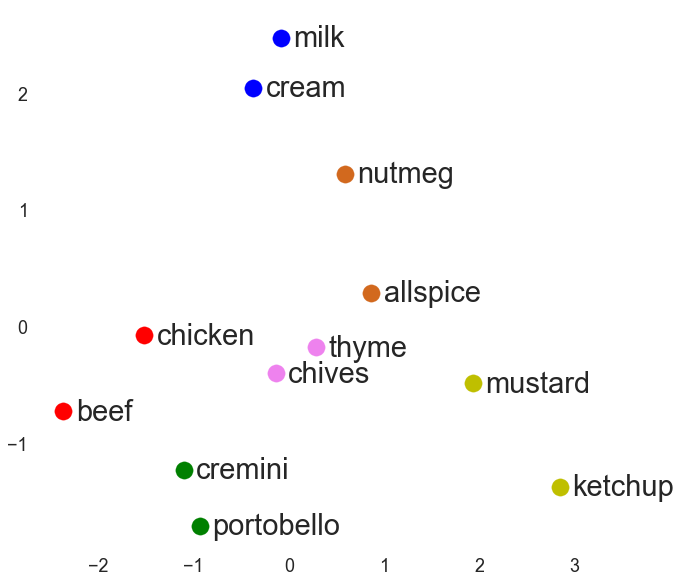

In [126]:
fcolors = ['g','g','violet','violet','chocolate','chocolate','r','r','b','b','y','y']
labels = ['cremini','portobello','thyme','chives','nutmeg','allspice','beef','chicken','milk','cream','mustard','ketchup']
# parmesan and pepper jack
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

alpha = 1

vp = mpatches.Patch(color='g', label='Vegetables',alpha=alpha)
hp = mpatches.Patch(color='violet', label='Herbs',alpha=alpha)
sp = mpatches.Patch(color='chocolate', label='Spices',alpha=alpha)
mp = mpatches.Patch(color='r', label='Meat',alpha=alpha)
dp = mpatches.Patch(color='b', label='Dairy',alpha=alpha)
cp = mpatches.Patch(color='y', label='Condiments',alpha=alpha)

for i in range(0,len(vecstack)):
    plt.scatter(fpcas[i,0], fpcas[i,1],s=300,c=fcolors[i],alpha=1)
    
# for i in range(0,len(gstack)):
#     plt.scatter(gpcas[i,0], gpcas[i,1],s=300,c=fcolors[i],alpha=0.5)
    

# plt.title('Ingredient Vectors',fontsize=24,y=1.08)
# plt.xlabel('PCAx',fontsize=18)
# plt.ylabel('PCAy',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax = plt.gca()
ax.set_facecolor('white')
ax.grid(b=False)
ax.set_frame_on(b=True)
# ax.set_xlim(-1.2,1.2);
# ax.set_ylim(-1.2,1.2);

for i, txt in enumerate(labels):
    ax.annotate(txt, (fpcas[i,0]+.13, fpcas[i,1]-.08), fontsize=29)

# for i, txt in enumerate(gnames):
#     ax.annotate(txt, (gpcas[i,0], gpcas[i,1]), fontsize=20)

# lgd = ax.legend(handles=[vp,hp,sp,mp,dp,cp],fontsize=18,frameon=True,
#            edgecolor='k',facecolor='white',bbox_to_anchor=(1.35, 1))

plt.savefig('reping.png',transparent=True,bbox_extra_artists=(lgd,), bbox_inches='tight') 
# fig.savefig('samplefigure', )

## Images as points

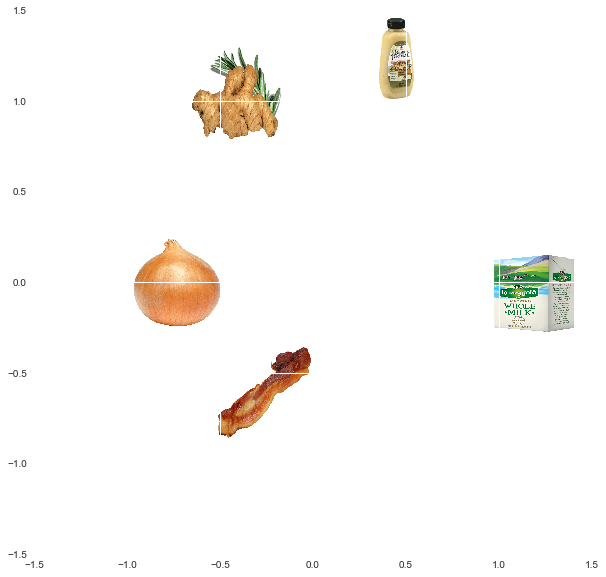

In [625]:
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

# Load images.
onion = plt.imread('onion.png')
thyme = plt.imread('thyme.png')
ginger = plt.imread('ginger.png')
bacon = plt.imread('bacon.png')
milk = plt.imread('milk.png')
mustard = plt.imread('mustard.png')


# Data
ox = [fpcas[0][0]]
oy = [fpcas[0][1]]
tx = [fpcas[3][0]]
ty= [fpcas[3][1]]
gx = [fpcas[6][0]]
gy= [fpcas[6][1]]
bx = [fpcas[9][0]]
by= [fpcas[9][1]]
mx = [fpcas[12][0]]
my= [fpcas[12][1]]
dx = [fpcas[15][0]]
dy= [fpcas[15][1]]

# Create figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Plots an image at each x and y location. 
def plotImage(xData, yData, im):
    for x, y in zip(xData, yData):
        bb = Bbox.from_bounds(x,y,.5,.5)  
        bb2 = TransformedBbox(bb,ax.transData)
        bbox_image = BboxImage(bb2,
                            norm = None,
                            origin=None,
                            clip_on=False)

        bbox_image.set_data(im)
        ax.add_artist(bbox_image)


plotImage(ox, oy, onion)
plotImage(tx, ty, thyme)
plotImage(gx, gy, ginger)
plotImage(bx, by, bacon)
plotImage(mx, my, milk)
plotImage(dx, dy, mustard)

# Set the x and y limits
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.5,1.5)

ax = plt.gca()
ax.set_facecolor('white')
plt.show()


## Next